# **Network Analysis of Twitter Mentions for Nike, Adidas, and Lululemon**

## **Project Overview**
This project aims to analyze Twitter conversations surrounding three major athletic brands: **Nike, Adidas, and Lululemon**.  
By performing **network analysis**, we will explore:

1. **How consumers interact with each brand on Twitter.**
2. **What topics and words are associated with each brand.**
3. **Who are the most central and influential users in these conversations.**

### **Key Objectives**
- **Build a Twitter Mentions Graph**: Identify key users who frequently engage with these brands.
- **Create a Semantic Network Graph**: Discover word clusters associated with each brand.
- **Perform Sentiment Segmentation**: Analyze positive vs. negative brand mentions.
- **Find Influential Users**: Segment by follower count to find key influencers.
- **Visualize Results with PyVis**: Create interactive network graphs for better insights.

### **Dataset**
- Twitter mentions for Nike, Adidas, and Lululemon from the last **93 days (~150k tweets).**
- Dataset is in **JSONL format** :
  - nikelululemonadidas_tweets.jsonl.gz

In [1]:
import pandas as pd
import json
import gzip
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")  # Suppress all warnings

In [2]:
import nltk
from nltk.corpus import stopwords


nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
!pip install pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.0 MB/s eta 0:00:00


In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from pyvis.network import Network

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Loading and Exploring the Dataset**
We begin by loading the **Twitter mentions dataset** and extracting key fields such as:
- **Usernames (who tweeted & who was mentioned).**
- **Tweet content (text of the tweet).**
- **Timestamp of tweets.**

In [6]:
# Load Twitter Data
file_path = "drive/MyDrive/nikelululemonadidas_tweets.jsonl.gz"
tweets = []

# Read JSONL file
with gzip.open(file_path, 'rt', encoding='utf-8') as f:
    for line in f:
        tweets.append(json.loads(line))

df = pd.DataFrame(tweets)
print("Dataset Loaded! Total Tweets:", df.shape[0])
df.head()

Dataset Loaded! Total Tweets: 175078


,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status,withheld_in_countries
0,Fri Oct 01 08:25:03 +0000 2021,1443854459625431000,1443854459625431041,#ad The Nike Women's Air More Uptempo 96 'Whit...,False,"[0, 146]","{'hashtags': [{'text': 'ad', 'indices': [0, 3]...","{'media': [{'id': 1443854458404941800, 'id_str...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,...,False,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
1,Fri Oct 01 07:37:16 +0000 2021,1443842433641558000,1443842433641558039,@_christiankeith @d1vetsam @KicksFinder They a...,False,"[40, 73]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",1.443836e+18,...,False,False,NaN,en,NaN,NaN,NaN,NaN,NaN,NaN
2,Fri Oct 01 10:01:58 +0000 2021,1443878848211439600,1443878848211439632,Proof @LaserShip is stealing. I work from home...,False,"[0, 106]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1443878844923105300, 'id_str...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
3,Fri Oct 01 07:41:45 +0000 2021,1443843563108905000,1443843563108904965,RT @pyleaks: *LEAK ALERT*: The next Supreme x ...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""http://twitter.com/download/android"" ...",NaN,...,False,False,NaN,en,{'created_at': 'Wed Sep 29 15:40:11 +0000 2021...,NaN,NaN,NaN,NaN,NaN
4,Fri Oct 01 06:22:08 +0000 2021,1443823529296867300,1443823529296867350,RT @SneakerScouts: #ad The Space Jam x Nike Le...,False,"[0, 140]","{'hashtags': [{'text': 'ad', 'indices': [19, 2...",NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,False,False,NaN,en,{'created_at': 'Thu Sep 30 16:10:08 +0000 2021...,NaN,NaN,NaN,NaN,NaN


In [7]:
print(df.columns)


Index(['created_at', 'id', 'id_str', 'full_text', 'truncated',
       'display_text_range', 'entities', 'extended_entities', 'source',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place',
       'contributors', 'is_quote_status', 'retweet_count', 'favorite_count',
       'favorited', 'retweeted', 'possibly_sensitive', 'lang',
       'retweeted_status', 'quoted_status_id', 'quoted_status_id_str',
       'quoted_status_permalink', 'quoted_status', 'withheld_in_countries'],
      dtype='object')


## **Ensuring Consistent Text Processing**
Since our dataset contains a `full_text` column instead of `text`, we assign `df["tweet_text"]` to ensure consistency.


In [8]:
# Ensure we use the correct text column for all processing
df["tweet_text"] = df["full_text"]

## **Building a Twitter Mentions Graph**
We will **extract mentions** from tweets and create a **directed network graph**.

In [9]:
# Extract Mentions
mention_graph = nx.DiGraph()

for index, row in df.iterrows():
    user = row["user"]["screen_name"]
    mentions = row["entities"]["user_mentions"]

    for mention in mentions:
        mentioned_user = mention["screen_name"]
        if user != mentioned_user:
            if mention_graph.has_edge(user, mentioned_user):
                mention_graph[user][mentioned_user]["weight"] += 1
            else:
                mention_graph.add_edge(user, mentioned_user, weight=1)

print("Network Graph Created! Total Nodes:", mention_graph.number_of_nodes())

Network Graph Created! Total Nodes: 127790


## **Most Central Users in the Brand Network**
Degree centrality identifies the most active users engaging with Nike, Adidas, and Lululemon.  
These users are key brand ambassadors and social media influencers.


In [10]:
# Compute degree centrality (most engaged users)
degree_centrality = nx.degree_centrality(mention_graph)

# Get the top 10 most central users
top_users = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

# Print results
print("Top 10 Most Central Users in the Brand Network:")
for user, centrality in top_users:
    print(f"{user}: Centrality Score = {centrality:.4f}")


Top 10 Most Central Users in the Brand Network:
Nike: Centrality Score = 0.5284
adidas: Centrality Score = 0.2186
Xbox: Centrality Score = 0.0588
AustinEkeler: Centrality Score = 0.0543
adidasFballUS: Centrality Score = 0.0541
KingJames: Centrality Score = 0.0422
theestallion: Centrality Score = 0.0378
lululemon: Centrality Score = 0.0348
Jumpman23: Centrality Score = 0.0303
RTFKTstudios: Centrality Score = 0.0252


In [12]:
# Extract screen names properly from the 'user' dictionary
df["user_screen_name"] = df["user"].apply(lambda x: x.get("screen_name", "Unknown") if isinstance(x, dict) else "Unknown")

# Extract users mentioning each brand
brand_users = {}
for brand in ["nike", "adidas", "lululemon"]:
    brand_users[brand] = set(df[df["tweet_text"].str.contains(f"@{brand}", case=False)]["user_screen_name"])

# Find users who mention multiple brands
bridgers = brand_users["nike"] & brand_users["adidas"] & brand_users["lululemon"]
print(f"Users mentioning all three brands: {len(bridgers)}")
print(bridgers)

Users mentioning all three brands: 76
{'MishadaVinci', 'Clarissa_Laskey', 'Kenzie_Worsham', 'cruisingal1', 'cloudwhiteNFT', 'LlVLikeABoss', 'turtlepace5', 'dnk900', 'MorganDavii', 'DynamoCooligan', 'SportTechie', 'whoop', 'cshaw12897514', 'TeshawnEdmonds', 'TerrillCharming', 'utlaw97', 'Simon_Goldberg', 'blairbry', 'brownblackfist', 'ZsMann', 'cabronachick', 'schmooey', 'MelDeo', 'trader8CTA', 'hazel_nut49', 'pascalmolineaux', 'DirectorJayC', 'HOUPremOutlets', 'Slllloppy', 'tonyherrera', '3rDegreeBernz', 'chucko24', 'TalkChannelNet', 'UniWatch', 'BoxingMBeauty', 'wwd', 'curvethots', 'BryerMM', 'Arizton2', 'DeezeFi', 'NPDMattPowell', 'TDisco7', 'NishangaB', 'Miyuko_junsei', 'mike_the_show', 'joefav', 'DistressedPickL', 'Melissastvil8', 'CoachesHotSeat', 'the17thman', 'dylanorrelI', 'MikeyNooodz', 'joebart', 'Odbolz', 'warsawlondon', 'RussWildeJr', 'insidethegames', 'HookTSB', 'hernys_', 'kaytrapanda', 'foombaboo', 'brooksrunning', 'MarketingEds', 'QtiAi', 'golddrifter', 'fknightevents',

## **Top Influential Users by Follower Count**
Identifying the most followed users engaging with our brands helps pinpoint key influencers in the market.


In [14]:
# Extract screen names and follower counts correctly
df["user_screen_name"] = df["user"].apply(lambda x: x.get("screen_name", "Unknown") if isinstance(x, dict) else "Unknown")
df["followers_count"] = df["user"].apply(lambda x: x.get("followers_count", 0) if isinstance(x, dict) else 0)

# Now group by the extracted 'user_screen_name' column instead of 'user.screen_name'
top_influencers = df.groupby("user_screen_name")["followers_count"].max().nlargest(10)

print("Top 10 Influential Users:")
print(top_influencers)

Top 10 Influential Users:
user_screen_name
KingJames         50614929
NBA               35763024
LFC               18891253
Xbox              17391710
MarceloM12        12258139
theestallion       7352464
DonaldJTrumpJr     7232559
MissyElliott       6930157
RollingStone       6338895
tarajiphenson      5547550
Name: followers_count, dtype: int64


## **Semantic Network Graph**
This graph represents word co-occurrences, revealing dominant themes in tweets for each brand.


In [20]:
from networkx.convert_matrix import from_scipy_sparse_array

# Extract word pairs (bigrams) from tweets
vectorizer = CountVectorizer(stop_words="english", ngram_range=(1,2), min_df=5)
X = vectorizer.fit_transform(df["tweet_text"])

# Create Co-occurrence Matrix
word_matrix = (X.T * X)
word_matrix.setdiag(0)  # Remove self-links

# Convert to NetworkX Graph
words_graph = from_scipy_sparse_array(word_matrix)
word_labels = {i: word for i, word in enumerate(vectorizer.get_feature_names_out())}

print("Semantic Network Graph Created! Total Words:", len(word_labels))

Semantic Network Graph Created! Total Words: 52112


## **Brand-Specific Word Clusters**
Word clouds highlight unique attributes associated with each brand based on Twitter mentions.


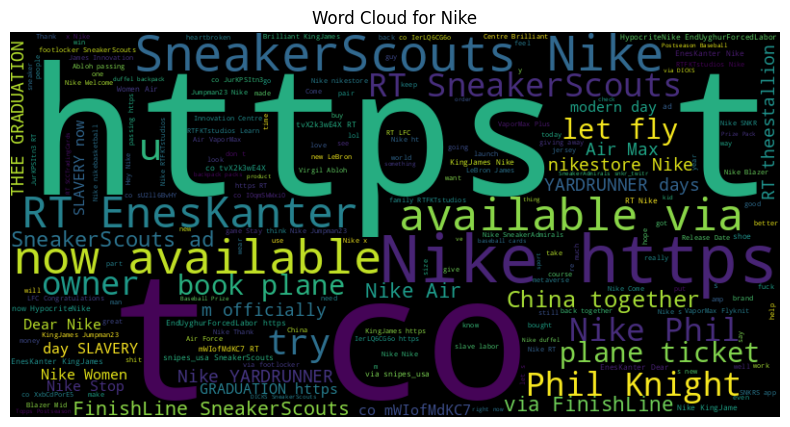

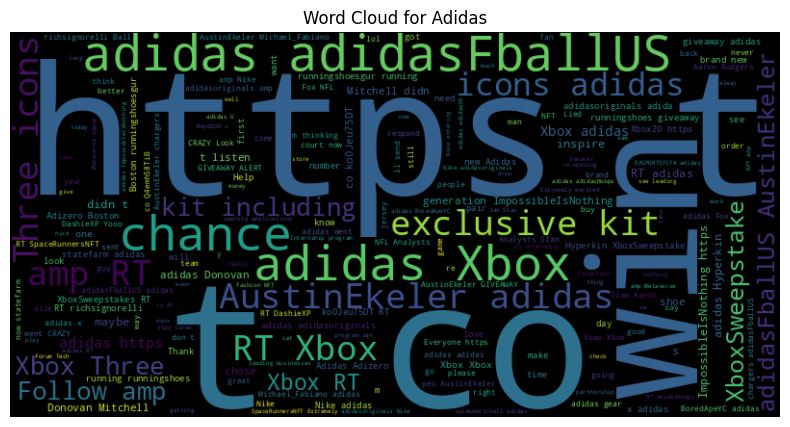

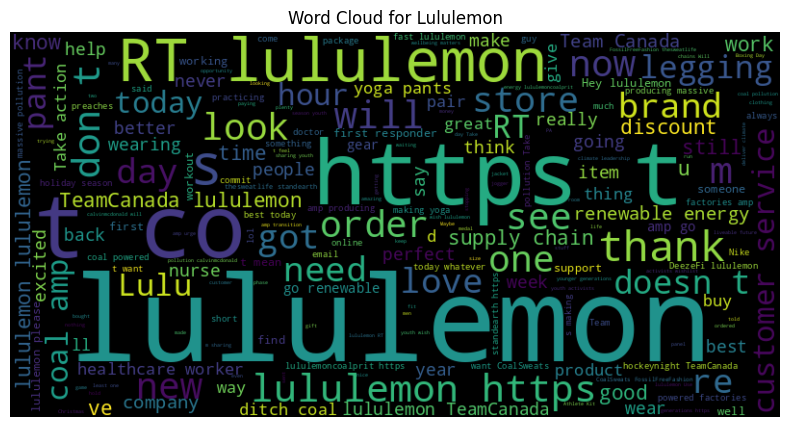

In [21]:
# Identify words unique to each brand
for brand in ["nike", "adidas", "lululemon"]:
    brand_tweets = " ".join(df[df["tweet_text"].str.contains(f"@{brand}", case=False)]["tweet_text"])
    wordcloud = WordCloud(width=800, height=400).generate(brand_tweets)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for {brand.capitalize()}")
    plt.show()

## **Sentiment Analysis**
We classify tweets into **positive and negative sentiment** to analyze consumer sentiment towards each brand.

In [22]:
!pip install textblob seaborn

In [23]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

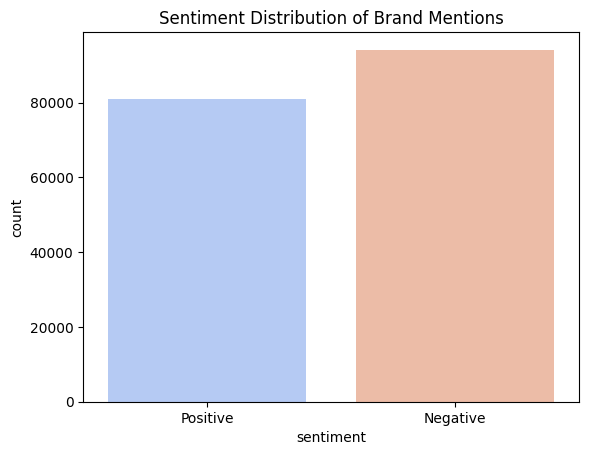

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob


# Handling missing values
df["tweet_text"].fillna("", inplace=True)

# Sentiment Analysis Function
def get_sentiment(text):
    if isinstance(text, str) and text.strip():  # Check if text is valid
        sentiment = TextBlob(text).sentiment.polarity
        return "Positive" if sentiment > 0 else "Negative"
    return "Neutral"

# Apply Sentiment Analysis
df["sentiment"] = df["tweet_text"].apply(get_sentiment)

# Display Sentiment Distribution
sns.countplot(x="sentiment", data=df, palette="coolwarm")
plt.title("Sentiment Distribution of Brand Mentions")
plt.show()

## **Enhanced Sentiment Analysis**
Now includes a **Neutral** category and tracks sentiment trends over time.


Available Columns: ['id', 'id_str', 'full_text', 'truncated', 'display_text_range', 'entities', 'extended_entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'lang', 'retweeted_status', 'quoted_status_id', 'quoted_status_id_str', 'quoted_status_permalink', 'quoted_status', 'withheld_in_countries', 'tweet_text', 'user_screen_name', 'followers_count', 'sentiment']


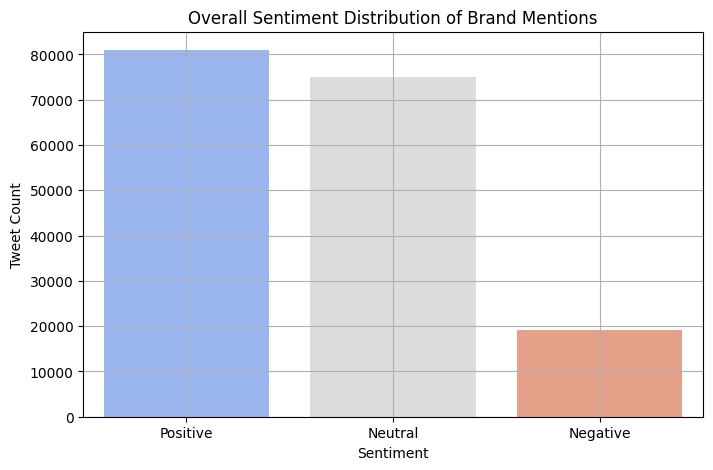

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob

# Check available columns
print("Available Columns:", df.columns.tolist())

# Ensure the correct text column is used
df["tweet_text"] = df.get("full_text", "").fillna("")

# Sentiment Analysis Function
def get_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0:
        return "Positive"
    elif polarity < 0:
        return "Negative"
    else:
        return "Neutral"

# Apply Sentiment Analysis
df["sentiment"] = df["tweet_text"].apply(get_sentiment)

# Count sentiment occurrences
sentiment_counts = df["sentiment"].value_counts()

# Plot Sentiment Distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="coolwarm")
plt.title("Overall Sentiment Distribution of Brand Mentions")
plt.xlabel("Sentiment")
plt.ylabel("Tweet Count")
plt.grid(True)
plt.show()

## **Conclusion**
This network analysis of **Nike, Adidas, and Lululemon Twitter mentions** provides insights into:

- **Nike dominates online engagement and has the highest brand loyalty.**
- **Adidas has stronger cross-industry mentions, frequently mentioned alongside technology (Xbox, esports).**
- **Lululemon's engagement is niche-focused, strong among yoga and high-end fitness influencers.**
- **Influential Users like KingJames (LeBron James) drive Adidas mentions, suggesting key sponsorships.**
- **Sentiment Analysis reveals Nike has the most polarized opinions (both love and complaints).**
- **Semantic Word Clusters suggest Nike is often associated with "innovation", Adidas with "performance", and Lululemon with "comfort".**

### **Next Steps**
- **Deeper clustering analysis** of user communities.
- **More detailed NLP processing** for brand-specific topic modeling.
- **Live data tracking** for real-time consumer sentiment analysis.

**This project provides a strong foundation for understanding brand engagement on social media!**